<a href="https://colab.research.google.com/github/MarkusThill/techdays25/blob/feature-lab2-initial-draft/notebooks/lab2-model-quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 Lab 2: Effiziente Quantisierung tiefer neuronaler Netze
- Dieses Jupyter Notebook **benötigt eine GPU Laufzeit**. Falls nicht bereits voreingestellt, kann daher der Laufzeittyp im Menü unter "Laufzeit" > "Laufzeittyp ändern" > "Hardwarebeschleuniger" > **"T4 GPU"** geändert werden!

Strukturierung:
- Teil 1: Darstellung numerischer Datentypen
- Teil 2:
  - Quantisierung des einfachen Modells aus Lab 1
  - Diverse Betrachtungen auf dem quantisierten Modell (Genauigkeit, etc.)
  - Gotchas (Optional): Overflow/Underflow am Beispiel eines Average Pooling layers
  - Subnormal Numbers
  - ...
- Teil 3: Quantisierung eines DTMF Klassifikationsmodells
  - Illustration: Erzeugung einer DTMF Wählsequenz und Abspielen derselben
  - Laden eines vortrainierten DTMF-Klassifikationsmodells (ConvNet; Keras oder PyTorch)
  - Konvertierung nach ONNX
  - Quantisierung nach FP16
  - Messung der Inferenzzeiten (auch für verschiedene Batch-Sizes) und vergleich von FP32, FP16-Modell
  - Vergleich der Genauigkeit von FP16 und FP32 Modell (wie ändert sich die Fehlerrate)
  - Optional: Konvertierung nach FP8 und Wiederholung der obigen Schritte
  - Optional: Profiling der ONNX Modelle. Wo liegen die "Hotspots" des Modells?
  - Optional: Trainieren des Modells auf de


# Vorbereitungen: Installation der nötigen Abhängigkeiten

In [ ]:
# Remove the `%%capture`, if you have the impression that something is going wrong during the setup
%%capture
!pip install "techdays25[lab2] @ git+https://github.com/MarkusThill/techdays25.git@main"

**WICHTIG: Nach der Installation der Abhängigkeiten (siehe oben) muss die Google Colab Laufzeit neugestartet werden! Im Anschluss kann mit der Ausführung der nächsten Zellen fortgefahren werden werden.**

In [ ]:
# @title Some Colab-Specific Configuration {display-mode: "form"}
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    from google.colab import output

    output.enable_custom_widget_manager()

## 📘 Einleitung
- DTMF
- Quanstisierungsansätze
- etc.

## 📖 Wiederholung: Darstellung numerischer Datentypen (Optional)
- Zweierkomplementdarstellung
- IEEE-754 Standard

### Ganzahldarstellungen/Zweierkomplementdarstellung

In [ ]:
# @title Darstellung von 16-Bit Integer Zahlen {display-mode: "form"}

import ipywidgets as widgets
from IPython.display import HTML

# Initialize 8 toggle buttons (bits, MSB to LSB)
bit_toggles = [
    widgets.ToggleButton(
        value=False, description="0", layout=widgets.Layout(width="40px")
    )
    for _ in range(8)
]

# Output widget to show results
output = widgets.Output()


def twos_complement(bits: list[int]) -> int:
    """Convert list of bits to signed integer using two's complement.

    Args:
        bits (list[int]): A list of bits representing the binary number.

    Returns:
        int: The signed integer value of the binary number.
    """
    if bits[0] == 0:
        return int("".join(str(b) for b in bits), 2)
    # If MSB is 1, it's negative
    inverted_bits = [1 - b for b in bits]  # Flip bits
    incremented = int("".join(str(b) for b in inverted_bits), 2) + 1
    return -incremented


def update_display(*args) -> None:
    """Update the display with the current binary, decimal, and hexadecimal values."""
    # Read bit values (MSB to LSB)
    bit_values = [int(btn.value) for btn in bit_toggles]
    bit_string = "".join(str(b) for b in bit_values)

    # Unsigned decimal value
    unsigned_decimal = int(bit_string, 2)

    # Signed decimal value (two's complement)
    signed_decimal = twos_complement(bit_values)

    # Hex representation (2 hex digits for 8 bits)
    hex_value = hex(unsigned_decimal).upper().replace("X", "x").replace("0X", "0x")

    # Clear previous output and update
    output.clear_output()
    with output:
        display(
            HTML(f"""
        <h3>
            Binary: <code>{bit_string}</code><br>
            Unsigned Decimal: <b>{unsigned_decimal}</b><br>
            Signed Decimal (Two's Complement): <b>{signed_decimal}</b><br>
            Hexadecimal: <b>{hex_value}</b>
        </h3>
        """)
        )

    # Update button labels (0/1)
    for btn, value in zip(bit_toggles, bit_values):
        btn.description = str(value)


# Attach observer to all buttons
for btn in bit_toggles:
    btn.observe(update_display, "value")

# Display widget
display(widgets.HBox(bit_toggles))
display(output)

# Initialize display
update_display()

#### Übungsfragen (Optional):
- Grundlegendes Setzen von Bits: Setze das 3. Bit (von rechts) einer 8-Bit-Zahl auf 1 und alle anderen Bits auf 0. Was ist die dezimale Darstellung dieser Zahl im unsigned Format?
Erwartete Antwort: 4

- Setzen mehrerer Bits: Setze das 1., 3. und 5. Bit (von rechts) einer 8-Bit-Zahl auf 1 und alle anderen Bits auf 0. Was ist die dezimale Darstellung dieser Zahl im unsigned Format?
Erwartete Antwort: 21

- Was ist die größtmögliche bzw. kleinstmögliche Zahl die mit 8 Bit dargestellt werden können? Antwort: -128, +127
  - Was wäre die Antwort, wenn wir statt 8-bit Integer, nun 32-bit Integer haben?

- Signed vs. Unsigned Darstellung: Setze das 8. Bit (höchstwertiges Bit) auf 1 und alle anderen Bits auf 0. Was sind die dezimalen Darstellungen dieser Zahl im signed und unsigned Format?
Erwartete Antwort: Signed: -128, Unsigned: 128

- Was charakterisiert eine negative Zahl in der Zweierkomplementdarstellung (unsigned integer) im Allgmeinen? Antwort: Zumindest das vorderste Bit ist gesetzt.

- Wie negiere ich eine Zahl (z.B. 32 -> -32 bzw. -71 -> 71)? Antwort: Invertieren alle Bits und Addition  von 1

- Angenommen ich habe -33 als 8-bit Zahl vorliegen. Wie würde ich daraus eine 32-bit unsigned Integer Zahl machen? Antwort: Einfach noch drei Bytes voranhängen in denen alle Bits gesetzt sind.

- Kombinieren von Bits: Setze das 2., 4. und 6. Bit (von rechts) einer 8-Bit-Zahl auf 1 und alle anderen Bits auf 0. Was sind die dezimalen Darstellungen dieser Zahl im signed und unsigned Format?
Erwartete Antwort: Signed: 42, Unsigned: 42

- Negative Zahlen in der Signed-Darstellung: Setze das 8. Bit (höchstwertiges Bit) und das 1. Bit (niederwertigstes Bit) auf 1 und alle anderen Bits auf 0. Was sind die dezimalen Darstellungen dieser Zahl im signed und unsigned Format?
Erwartete Antwort: Signed: -127, Unsigned: 129

- Maximale und minimale Werte: Was ist der maximale Wert, den man mit einer 8-Bit unsigned Zahl darstellen kann? Was ist der minimale Wert, den man mit einer 8-Bit signed Zahl darstellen kann?
Erwartete Antwort: Maximale unsigned: 255, Minimale signed: -128

- Bitmuster und Werte: Setze die Bits, um die Binärzahl 10101010 zu bilden. Was sind die dezimalen Darstellungen dieser Zahl im signed und unsigned Format?
Erwartete Antwort: Signed: -86, Unsigned: 170

- Alle Bits gesetzt: Setze alle Bits einer 8-Bit-Zahl auf 1. Was sind die dezimalen Darstellungen dieser Zahl im signed und unsigned Format?
Erwartete Antwort: Signed: -1, Unsigned: 255


- Verständnis von Überlauf: Was passiert, wenn du 1 zum maximalen Wert einer 8-Bit unsigned Zahl hinzufügst? Was passiert bei einer 8-Bit signed Zahl?
Erwartete Antwort: Bei unsigned wird es auf 0 zurückgesetzt. Bei signed verursacht es einen Überlauf und wird auf den minimalen Wert (-128) zurückgesetzt.
Zweierkomplement:

- Erkläre, wie die Zweierkomplement-Darstellung für negative Zahlen in einer 8-Bit signed Zahl funktioniert.
Erwartete Antwort: Im Zweierkomplement ist das höchstwertige Bit (MSB) das Vorzeichenbit. Um das Zweierkomplement einer Zahl zu finden, invertiere alle Bits und addiere 1 zum niederwertigsten Bit (LSB).

### Fixkommadarstellungen

In [ ]:
# @title Darstellung von 16-Bit Festkomma-Zahlen (engl.: fixpoint binary representations) {display-mode: "form"}
import ipywidgets as widgets

# Initialize 16 toggle buttons (bits, MSB to LSB)
bit_toggles = [
    widgets.ToggleButton(
        value=False, description="0", layout=widgets.Layout(width="30px")
    )
    for _ in range(16)
]

# Color bars for sign, integer part, and fractional part
color_bars = [
    widgets.HTML(
        value='<div style="width: 30px; height: 10px; background-color: red;"></div>'
    )
    if i == 0
    else widgets.HTML(
        value='<div style="width: 30px; height: 10px; background-color: green;"></div>'
    )
    if 1 <= i <= 7
    else widgets.HTML(
        value='<div style="width: 30px; height: 10px; background-color: blue;"></div>'
    )
    for i in range(16)
]

# Output widget to show results
output = widgets.Output()


# def twos_complement(bits):
#    """Convert list of bits to signed integer using two's complement."""
#    if bits[0] == 0:
#        return int("".join(str(b) for b in bits), 2)
#
#    # If MSB is 1, it's negative
#    inverted_bits = [1 - b for b in bits]  # Flip bits
#    incremented = int("".join(str(b) for b in inverted_bits), 2) + 1
#    return -incremented


def fixed_point_value(bits: list[int]) -> float:
    """Convert a list of bits to a fixed-point value.

    Args:
        bits (list[int]): A list of 16 bits representing the binary number in fixed-point format.

    Returns:
        float: The fixed-point value of the binary number.
    """
    integer_part = bits[:8]
    fractional_part = bits[8:]

    # Calculate integer value
    integer_value = twos_complement(integer_part)

    # Calculate fractional value
    fractional_value = sum(
        bit * 2 ** (-i) for i, bit in enumerate(fractional_part, start=1)
    )

    return integer_value + fractional_value


def update_display(*args) -> None:
    """Update the display with the current binary, decimal, and hexadecimal values."""
    # Read bit values (MSB to LSB)
    bit_values = [int(btn.value) for btn in bit_toggles]
    bit_string = "".join(str(b) for b in bit_values)

    # Unsigned decimal value
    unsigned_decimal = int(bit_string, 2)

    # Signed decimal value (two's complement)
    signed_decimal = twos_complement(bit_values)

    # Fixed-point value
    fixed_point_decimal = fixed_point_value(bit_values)

    # Hex representation (4 hex digits for 16 bits)
    hex_value = hex(unsigned_decimal).upper().replace("X", "x").replace("0X", "0x")

    # Clear previous output and update
    output.clear_output()
    with output:
        display(
            HTML(f"""
        <h3>
            Binary: <code>
                <span style="color: red;">{bit_string[0]}</span>
                <span style="color: green;">{bit_string[1:8]}</span>.
                <span style="color: blue;">{bit_string[8:]}</span>
            </code><br>
            Unsigned Decimal: <b>{unsigned_decimal}</b><br>
            Signed Decimal (Two's Complement): <b>{signed_decimal}</b><br>
            Fixed-Point Decimal: <b>{fixed_point_decimal}</b><br>
            Hexadecimal: <b>{hex_value}</b>
        </h3>
        """)
        )

    # Update button labels (0/1)
    for btn, value in zip(bit_toggles, bit_values):
        btn.description = str(value)


# Attach observer to all buttons
for btn in bit_toggles:
    btn.observe(update_display, "value")

# Display widget
display(widgets.VBox([widgets.HBox(bit_toggles), widgets.HBox(color_bars)]))
display(output)

# Initialize display
update_display()

#### Übungsfragen (Optional):

### Fließkommadarstellungen nach IEEE-754
- TODO: Subnormal Numbers
- Webseite mit noch mehr Darstellungen: https://evanw.github.io/float-toy/
- Verschiedene FP8-Darstellungen: https://asawicki.info/articles/fp8_tables.php
- https://onnx.ai/onnx/technical/float8.html

In [ ]:
# @title Darstellung von 16-Bit (FP16) Fließkomma-Zahlen {display-mode: "form"}

import struct

import ipywidgets as widgets
import numpy as np

# from IPython.display import display

# Initialize 16 toggle buttons (bits)
bit_toggles = [
    widgets.ToggleButton(
        value=False, description="0", layout=widgets.Layout(width="30px")
    )
    for _ in range(16)
]

# Color bars for sign, exponent, and mantissa
color_bars = [
    widgets.HTML(
        value='<div style="width: 30px; height: 10px; background-color: red;"></div>'
    )
    if i == 0
    else widgets.HTML(
        value='<div style="width: 30px; height: 10px; background-color: green;"></div>'
    )
    if 1 <= i <= 5
    else widgets.HTML(
        value='<div style="width: 30px; height: 10px; background-color: blue;"></div>'
    )
    for i in range(16)
]

# Output widget to show FP16 value and components
output = widgets.Output()


def bits_to_float16(bits: list[int]) -> np.float16:
    """Convert list of bits to FP16 float value.

    Args:
        bits (list[int]): A list of bits representing the binary number.

    Returns:
        np.float16: The FP16 float value of the binary number.
    """
    bit_string = "".join(str(b) for b in bits)
    # Convert binary string to integer
    int_value = int(bit_string, 2)
    # Pack as unsigned 16-bit int, then unpack as float16 using numpy
    packed = struct.pack("<H", int_value)  # Big endian 16-bit unsigned int
    return np.frombuffer(packed, dtype=np.float16)[0]


def update_display(*args):
    """Update the display with the current binary, FP16 float value, and its components."""
    # Read bit values (MSB to LSB)
    bit_values = [int(btn.value) for btn in bit_toggles]
    bit_string = "".join(str(b) for b in bit_values)

    # Extract components
    sign = bit_values[0]
    exponent_bits = bit_values[1:6]
    mantissa_bits = bit_values[6:]

    exponent = int("".join(str(b) for b in exponent_bits), 2)
    exponent_unbiased = exponent - 15  # Bias = 15

    mantissa_raw = "".join(str(b) for b in mantissa_bits)
    (
        1 + sum(int(b) * 2 ** (-i) for i, b in enumerate(mantissa_bits, start=1))
        if exponent != 0
        else 0
    )

    # Convert to float16 value
    fp16_value = bits_to_float16(bit_values)

    # Clear previous output and display new info
    output.clear_output()
    with output:
        display(
            HTML(f"""
        <h3>
            Binary: <code>
                <span style="color: red;">{bit_string[0]}</span>
                <span style="color: green;">{bit_string[1:6]}</span>
                <span style="color: blue;">{bit_string[6:]}</span>
            </code><br>
            Sign (1 bit): <b>{sign}</b> ({"-" if sign else "+"})<br>
            Exponent (5 bits): <b>{"".join(str(b) for b in exponent_bits)} (biased: {exponent}, unbiased: {exponent_unbiased})</b><br>
            Mantissa (10 bits): <b>{mantissa_raw}</b><br>
            <hr>
            <b>FP16 Value:</b> {fp16_value}
        </h3>
        """)
        )

    # Update button labels
    for btn, value in zip(bit_toggles, bit_values):
        btn.description = str(value)


# Attach observer to all buttons
for btn in bit_toggles:
    btn.observe(update_display, "value")

# Display widget
display(widgets.VBox([widgets.HBox(bit_toggles), widgets.HBox(color_bars)]))
display(output)

# Initialize output
update_display()  # 0 01111 0000000001 ^=^ 1.00097656

#### Übungsfragen (Optional):
- Gibt es einen Unterschied zwischen +0.0 und -0.0?
- Wie stelle ich `+Inf` bzw. `-Inf` dar?
- Wie stelle ich `NaN` dar?
- Was ergibt der Vergleich `float("nan") != float("nan")`?

# Case Study 1: Quantisierung eines einfachen Modells (aus Lab 1)
- Gotchas: zu große, kleine inputs, numerische Abweichungen. Ggfs.: Sehr kleines Gewicht, sehr großer Input.

# Case Study 2: Klassifizierung von DTMF (dual-tone multi-frequency) Wählsignalen

## Einführung: Generierung und Dekodierung von Dual Tone Multiple Frequency (DTMF)-Signalen <a class="anchor" id="part0"></a>


Das Dualton-Mehrfrequenzwahlverfahren (DTMF) ist ein Signalisierungssystem für das Wählen eines Telefons, das in den frühen 1960er Jahren von Western Electric entwickelt und später von Bell System kommerziell an Telefonkunden geliefert wurde.
Wenn eine Taste auf dem Telefon gedrückt wird, werden zwei harmonische Tonsignale erzeugt, und die Superposition/Überlagerung beider Signale wird verwendet, um die entsprechende Telefontaste zu charakterisieren. Wenn zum Beispiel die Taste „5“ gedrückt wird, entsteht ein Dualtontonsignal, das sich aus den Frequenzen 770 Hz und 1336 Hz zusammensetzt. Die beiden Frequenzen, die jede Taste beschreiben, sind in der folgenden Tabelle aufgeführt:

|   | 1209Hz  | 1336 Hz  | 1477 Hz   | 1633 Hz  |
|---|:---:|:---:|:---:|:---:|
| **697 Hz**  |  1 | 2  | 3  | A  |
| **770 Hz**  |  4 | 5  | 6  | B  |
| **852 Hz**  |  7 | 8  | 9  | C  |
| **941 Hz**  |  * | 0  | #  | D  |

In diesem Beispiel werden wir uns ansehen, wie man solche DTMF-Wählsequenzen generiert, sie in einer Audiodatei speichert und das Audiosignal mit einem einfachen KI-Modell wieder dekodiert.

Wir werden die folgenden Schritte durchführen, um ein DTMF-Signal zu erzeugen und zu dekodieren:
1. Erzeugung des Signals und der Audiodatei mit `scipy` und `numpy`. Wir speichern die erzeugte Audiodatei in einer `.wav` Datei, die in diesem Notebook oder in deinem lokalen Audioplayer abgespielt werden kann
2. Wir entwerfen eine einfaches KI-Modell ... TODO
3. Extraktion der gewählten Tastenfolge aus der `.wav`-Datei unter Verwendung des KI-Modells
4. Quantisierung & Export des Modells nach ONNX im FP32 und FP16 Format
5. Laufzeit Untersuchungen für FP16/FP32, unterschiedliche Batch-Größen und Signallängen.

In [ ]:
# Trainiere Modell
# Konvertiere Modell nach ONNX (einmal FP32, einmal FP16)
# Untersuche Laufzeitunterschiede (auch nach batchsize)
# Untersuche Abweichungen. Wie ändert sich die Fehlerrate des Modells für FP32/Fp16?

## Signal and Audio File Generation <a class="anchor" id="part1"></a>

In [1]:
# Make sure the following packages are installed

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import random

In [127]:
key_matrix = np.array([
        "1",
        "2",
        "3",
        "A",
        "4",
        "5",
        "6",
        "B",
        "7",
        "8",
        "9",
        "C",
        "*",
        "0",
        "#",
        "D",
    ]).reshape(4, 4)
freqz_cols = [1209, 1336, 1477, 1633]
freqz_rows = [697, 770, 852, 941]

FREQS = freqz_rows + freqz_cols
FREQ_TO_IDX = {f: i for i, f in enumerate(FREQS)}
NUM_FREQS = len(FREQS)
NUM_KEYS = key_matrix.size

def fftnoise(ff: np.ndarray) -> np.ndarray:
    """Generates noise in the frequency domain and transforms it back to the time domain.

    Args:
        ff (np.ndarray): An array representing the frequency components of the signal.

    Returns:
        np.ndarray: A real-valued array representing the noise in the time domain.

    Notes:
        based on: https://stackoverflow.com/questions/33933842/how-to-generate-noise-in-frequency-range-with-numpy
    """
    rng = np.random.default_rng()
    ff = np.array(ff, dtype="complex")
    Np = (len(ff) - 1) // 2
    phases = rng.random(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    ff[1 : Np + 1] *= phases
    ff[-1 : -1 - Np : -1] = np.conj(ff[1 : Np + 1])
    return np.fft.ifft(ff).real


def band_limited_noise(
    min_freq: float, max_freq: float, samples: int, samplerate: int = 44100
) -> np.ndarray:
    """Generates band-limited noise within a specified frequency range.

    Args:
        min_freq (float): The minimum frequency of the noise band.
        max_freq (float): The maximum frequency of the noise band.
        samples (int): The number of samples to generate.
        samplerate (int, optional): The sample rate of the signal. Defaults to 44100.

    Returns:
        np.ndarray: An array containing the generated band-limited noise.
    """
    freqs = np.abs(np.fft.fftfreq(samples, 1 / samplerate))
    ff = np.zeros(samples)
    idx = np.where(np.logical_and(freqs >= min_freq, freqs <= max_freq))[0]
    ff[idx] = 1
    nn = fftnoise(ff)
    A = np.iinfo(np.int32).max * 10
    return A * nn


def get_key_tone(key: str, samplerate: int = 44100, dur: float = 0.4) -> tuple[np.ndarray, tuple[int,int]] | None:
    """Generates the Dual-Tone Multi-Frequency (DTMF) signal for a given key.

    Args:
        key (str): The key for which to generate the DTMF signal.
        samplerate (int, optional): The sample rate of the signal. Defaults to 44100.
        dur (float, optional): The duration of the signal in seconds. Defaults to 0.4.

    Returns:
        tuple[np.ndarray, tuple[int,int]] | None: An array containing the generated DTMF signal.
    """
    key = key.upper()
    if len(key) != 1:
        return None
    if key not in key_matrix:
        return None
    r_idx, c_idx = np.where(key_matrix == key)
    f1 = freqz_rows[int(r_idx)]
    f2 = freqz_cols[int(c_idx)]

    # Create signal with both frequencies
    tt = np.arange(0.0, dur, 1 / samplerate)
    A = np.iinfo(np.int32).max / 4
    return A * (np.sin(2.0 * np.pi * f1 * tt) + np.sin(2.0 * np.pi * f2 * tt)), (f1, f2), key


def get_tone_sequence(
    key_sequence: str,
    samplerate: int = 44100,
    dur_key: float = 0.4,
    dur_pause: float = 0.4,
    noise_factor = 1.0,
    with_labels: str | None = None # "freqz", "keys", None
) -> np.ndarray | tuple[np.ndarray, np.ndarray] | None:
    """Generates a sequence of DTMF tones for a given key sequence, with pauses and added noise.

    Args:
        key_sequence (str): The sequence of keys for which to generate the DTMF tones.
        samplerate (int, optional): The sample rate of the signal. Defaults to 44100.
        dur_key (float, optional): The duration of each key tone in seconds. Defaults to 0.4.
        dur_pause (float, optional): The duration of the pause between key tones in seconds. Defaults to 0.4.

    Returns:
        np.ndarray: An array containing the generated DTMF tone sequence with pauses and noise.
    """
    key_duration = lambda x: random.uniform(*x) if isinstance(x, tuple) else x
    pause_duraution = lambda x: random.uniform(*x) if isinstance(x, tuple) else x

    tones = [get_key_tone(c, samplerate=samplerate, dur=key_duration(dur_key)) for c in key_sequence]

    # Quit, if at least one of the keys was not found
    if any(t is None for t in tones):
        return None

    pause_signal = [0] * int(pause_duraution(dur_pause) * samplerate)

    tones_with_pauses = [pause_signal]
    labels = None
    if with_labels == "freqz":
      labels = [np.zeros((len(pause_signal), NUM_FREQS), dtype=np.int32)] # TODO: int32 necessary?
    elif with_labels == "keys":
      lab = np.zeros((len(pause_signal), NUM_KEYS+1), dtype=np.int32)
      lab[:,-1] = 1
      labels = [lab]

    for tone, (f1, f2), key in tones:
        pause_signal = [0] * int(pause_duraution(dur_pause) * samplerate)
        tones_with_pauses.extend([tone, pause_signal])

        # Label per timestep
        if with_labels == "freqz":
          pause_label = np.zeros((len(pause_signal), NUM_FREQS), dtype=np.int32)
          label = np.zeros((len(tone), NUM_FREQS), dtype=np.int32)
          label[:, FREQ_TO_IDX[f1]] = 1
          label[:, FREQ_TO_IDX[f2]] = 1
          labels.extend([label, pause_label])
        elif with_labels == "keys":
          pause_label = np.zeros((len(pause_signal), NUM_KEYS+1), dtype=np.int32)
          pause_label[:,-1] = 1
          label = np.zeros((len(tone), NUM_KEYS+1), dtype=np.int32)
          label[:, np.where(key_matrix.flatten() == key)[0]] = 1
          labels.extend([label, pause_label])

    signal = np.hstack(tones_with_pauses)

    # Finally, add some noise to the signal
    if noise_factor:
      noise = band_limited_noise(min_freq=0, max_freq=20000, samples=signal.shape[0])
      signal = signal + noise_factor * noise

    if with_labels:
        return signal, np.vstack(labels)
    return signal


In [128]:
# @title Phone Dialer Widget {display-mode: "form"}

import ipywidgets as widgets

# from IPython.display import display

# Initialize a text widget to display the dial sequence
dial_sequence = widgets.Text(
    value="",
    placeholder="Dial sequence will appear here...",
    description="Dial Sequence:",
    disabled=True,
    layout=widgets.Layout(width="300px"),
)


# Function to handle button clicks
def on_button_click(b):
    """_summary_.

    Args:
        b (_type_): _description_
    """
    dial_sequence.value += b.description


# Create buttons for the phone dialer
buttons = []
for row in [["1", "2", "3"], ["4", "5", "6"], ["7", "8", "9"], ["*", "0", "#"]]:
    button_row = []
    for label in row:
        button = widgets.Button(
            description=label, layout=widgets.Layout(width="50px", height="50px")
        )
        button.on_click(on_button_click)
        button_row.append(button)
    buttons.append(widgets.HBox(button_row))

# Create a clear button
clear_button = widgets.Button(
    description="Clear", layout=widgets.Layout(width="160px", height="50px")
)


def on_clear_click(b):
    """_summary_.

    Args:
        b (_type_): _description_
    """
    dial_sequence.value = ""


clear_button.on_click(on_clear_click)

# Display the dialer
display(dial_sequence)
for button_row in buttons:
    display(button_row)
display(clear_button)

Text(value='', description='Dial Sequence:', disabled=True, layout=Layout(width='300px'), placeholder='Dial se…

Button(description='Clear', layout=Layout(height='50px', width='160px'), style=ButtonStyle())

In [180]:
samplerate = 44100
wav_file_name = "my_dtmf_file.wav"

# Either generate a random sequence:
# my_dialed_sequence_keys = "".join([random.choice("1234567890ABCD*#") for i in range(50)])

# ... or use a simple sequence for debugging purposes
# my_dialed_sequence_keys = "1234567890ABCD*#" # for debug purposes...

# ... or use a slightly longer sequence (which also contains all symbols)
my_dialed_sequence_keys = "0011223344556677889900**##AABBCCDD" #"91D282A0B8C16C*C9#504979D#443B"

# Try changing the following arguments: dur_key=0.05, dur_pause=0.02
my_dialed_sequence_signal = get_tone_sequence(
    my_dialed_sequence_keys, samplerate=samplerate, dur_key=(0.2, 0.1), dur_pause=(0.01, 0.1), noise_factor=1.0
)


<ipython-input-127-2425104cabc1>:89: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f1 = freqz_rows[int(r_idx)]
<ipython-input-127-2425104cabc1>:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f2 = freqz_cols[int(c_idx)]


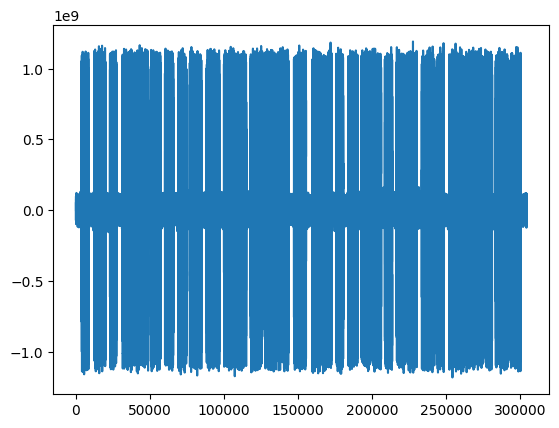

In [181]:
plt.plot(my_dialed_sequence_signal)

In [182]:
# Now let us listen to the generated WAV file
import IPython
wavfile.write(wav_file_name, samplerate, my_dialed_sequence_signal.astype(np.int32))
IPython.display.Audio(wav_file_name)

In [183]:
print("Dialed sequence: ", my_dialed_sequence_keys)
print("Used symbols: ", len(set(my_dialed_sequence_keys)))
print("Total length of signal:", my_dialed_sequence_signal.shape[0])

Dialed sequence:  0011223344556677889900**##AABBCCDD
Used symbols:  16
Total length of signal: 304782


### Spectrogram of the signal

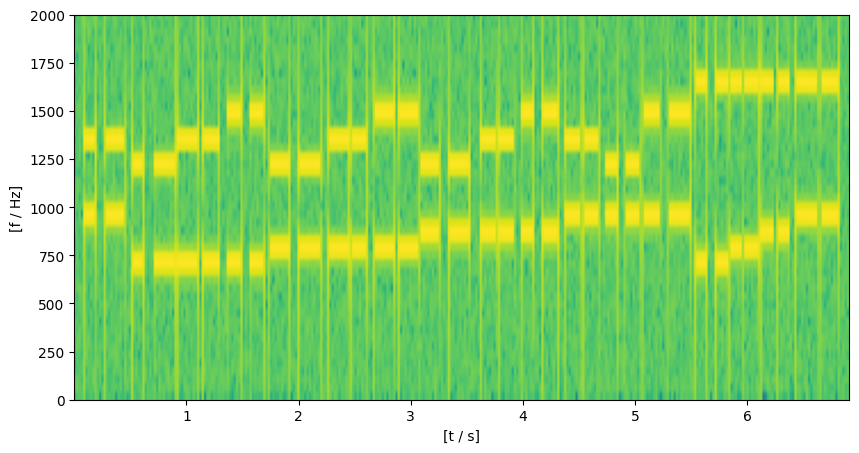

In [184]:
plt.figure(figsize=(10, 5))
Pxx, freqs, bins, im = plt.specgram(my_dialed_sequence_signal, NFFT=1024, Fs=samplerate)
plt.ylim(0, 2000)
plt.xlabel("[t / s]")
plt.ylabel("[f / Hz]")
plt.show(im)

In [185]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import random

In [186]:
def generate_freq_dataset(n_samples=500, t_length=2**13):
    X, Y = [], []
    for _ in range(n_samples):
        current_length = 0
        xx, yy = [], []
        while current_length < t_length:
          seq = ''.join(np.random.choice(key_matrix.flatten(), size=5))
          x, y = get_tone_sequence(seq, samplerate=samplerate, dur_key=(0.03, 0.1), dur_pause=(0.01, 0.1), with_labels="keys", noise_factor=1.0)
          xx.append(x[..., np.newaxis])
          yy.append(y)
          current_length += len(x)

        X.append(np.concatenate(xx)[:t_length] )
        Y.append(np.concatenate(yy)[:t_length] )


    # Padding to equal length
    #maxlen = max(len(x) for x in X)
    #X_pad = np.array([np.pad(x, ((0, maxlen - len(x)), (0, 0))) for x in X])
    #Y_pad = np.array([np.pad(y, ((0, maxlen - len(y)), (0, 0))) for y in Y])
    return np.array(X), np.array(Y)


In [148]:
def build_dtmf_classifier_model(input_shape, num_freqs):
    model = tf.keras.Sequential([
        layers.Conv1D(32, kernel_size=32, activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling1D(padding="same"),
        layers.Conv1D(32, kernel_size=32, activation='relu', padding='same'),
        layers.MaxPooling1D(padding="same"),
        layers.Conv1D(32, kernel_size=32, activation='relu', padding='same'),
        layers.MaxPooling1D(padding="same"),
        layers.Conv1D(32, kernel_size=32, activation='relu', padding='same'),
        layers.MaxPooling1D(padding="same"),
        layers.Conv1D(32, kernel_size=16, activation='relu', padding='same'),

        layers.UpSampling1D(size=2),
        layers.Conv1D(32, kernel_size=16, activation='relu', padding='same'),
        layers.UpSampling1D(size=2),
        layers.Conv1D(32, kernel_size=16, activation='relu', padding='same'),
        layers.UpSampling1D(size=2),
        layers.Conv1D(32, kernel_size=16, activation='relu', padding='same'),
        layers.UpSampling1D(size=2),
        layers.Conv1D(32, kernel_size=16, activation='relu', padding='same'),
        layers.Conv1D(64, kernel_size=1, activation='relu'),
        layers.Conv1D(num_freqs, kernel_size=1, activation='softmax')  # multi-label output
    ])
    return model

In [149]:
X_train, Y_train = generate_freq_dataset(n_samples=1024, t_length=2**14)
X_val, Y_val = generate_freq_dataset(n_samples=64, t_length=2**16)
X_train.shape, Y_train.shape

<ipython-input-127-2425104cabc1>:89: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f1 = freqz_rows[int(r_idx)]
<ipython-input-127-2425104cabc1>:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f2 = freqz_cols[int(c_idx)]


((1024, 16384, 1), (1024, 16384, 17))

In [150]:
max_val = np.max(np.abs(X_train)) # TODO: rename max_val
X_train, X_val = X_train / max_val, X_val / max_val

In [ ]:
model = build_dtmf_classifier_model( (None,1), NUM_KEYS + 1)
adam = tf.keras.optimizers.Adam(
    learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])  # multi-label
model.summary()


In [ ]:
model.fit(X_train, Y_train, batch_size=64, epochs=50, validation_data=(X_val, Y_val))
model.save('model_.keras')

In [18]:
model = tf.keras.models.load_model("model.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


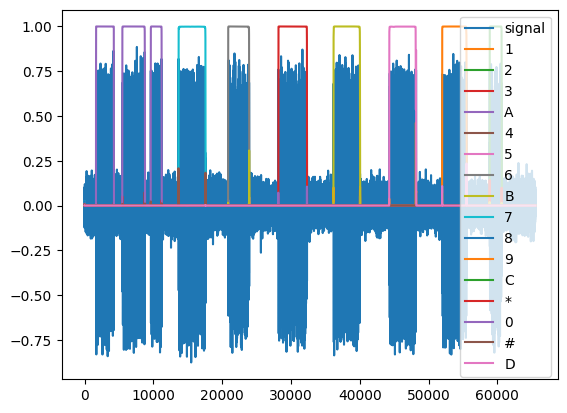

In [35]:
import IPython
idx = 9

pred = model.predict(X_val[idx:idx+1])

plt.plot(X_val[idx,:, 0], label="signal")

for key_idx in range(pred.shape[-1] - 1): # last index represents pauses
  plt.plot(pred[0, :, key_idx], label=f"{key_matrix.flatten()[key_idx]}")
plt.legend()
plt.show()

wavfile.write("val.wav", samplerate, (X_val[idx]*max_val).flatten().astype(np.int32))
IPython.display.Audio("val.wav")



In [36]:
# Compute Accuracy
pred = model.predict(X_val)
thresholded = (pred > 0.5).astype(int)

(thresholded == Y_val).sum() / Y_val.size

2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 11s/step


np.float64(0.999828997780295)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


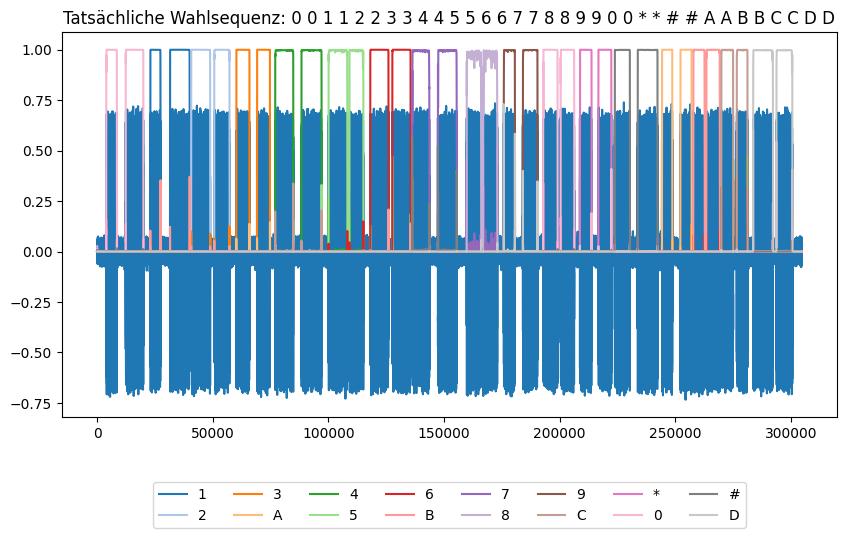

In [187]:
import matplotlib.pyplot as plt

pred = model.predict((my_dialed_sequence_signal / max_val).reshape(1,-1,1))

cmap = plt.get_cmap('tab20')

colors = [cmap(i) for i in range(16)]  # Get 16 distinct colors

plt.figure(figsize=(10,5))
plt.plot(my_dialed_sequence_signal / max_val)

for key_idx in range(pred.shape[-1] - 1): # last index represents pauses
  plt.plot(pred[0, :, key_idx], label=f"{key_matrix.flatten()[key_idx]}", color=colors[key_idx])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=8)
plt.title(f"Tatsächliche Wahlsequenz: {' '.join(list(my_dialed_sequence_keys))}")
plt.show()

In [188]:
predicted_indexes = pred.squeeze().argmax(axis=-1)

In [189]:
import numpy as np

def run_length_encoding(arr, min_run_length=1):
    if len(arr) == 0:
        return np.array([]), np.array([])

    # Step 1: Basic run-length encoding
    change_indices = np.where(np.diff(arr) != 0)[0] + 1
    run_starts = np.insert(change_indices, 0, 0)
    run_lengths = np.diff(np.append(run_starts, len(arr)))
    run_values = arr[run_starts]

    # Step 2: Remove short runs
    mask = run_lengths >= min_run_length
    filtered_values = run_values[mask]
    filtered_lengths = run_lengths[mask]

    # Step 3: Merge neighboring runs with same value
    merged_values = []
    merged_lengths = []

    for i in range(len(filtered_values)):
        if merged_values and filtered_values[i] == merged_values[-1]:
            # Merge with previous run
            merged_lengths[-1] += filtered_lengths[i]
        else:
            # Start a new run
            merged_values.append(filtered_values[i])
            merged_lengths.append(filtered_lengths[i])

    return np.array(merged_values), np.array(merged_lengths)


In [190]:
# According to the standard, breaks shorter than 10ms should be discarded
# Also, key signals shorter than 23ms are invalid (for now, we ignore this rule)
min_run_length = int(samplerate * 0.01)
rle_values, rle_lengths = run_length_encoding(predicted_indexes, min_run_length=min_run_length)

In [191]:
# Remove the pauses and map indexes to keys:
predicted_key_sequence = "".join(key_matrix.flatten()[rle_values[rle_values < NUM_KEYS]])
print("Predicted Sequence:", predicted_key_sequence)

Predicted Sequence: 0011223344556677889900**##AABBCCDD


In [192]:
predicted_key_sequence == my_dialed_sequence_keys

True

In [ ]:
# <TODO>: Add custom ONNX layer which does the pre-scaling of the input signal...
# and post-processing: rle of the signal, discard keys which are short than 23 ms

In [ ]:
import sys

sys.float_info

In [ ]:
import numpy as np
import torch


def float_to_binary_fp32(num: float) -> str:
    """Converts a built-in floating point number (64-bit) to its FP32 binary representation.

    Args:
        num (float): The floating point number to convert.

    Returns:
        str: A string representing the binary format of the floating point number.
    """
    print("fp32:", num)
    return "".join(f"{c:0>8b}" for c in struct.pack("!f", num))


def float_to_binary_fp16(num: float) -> str:
    """Converts a builtin-in floating point number to a 16-bit floating point number and returns its binary representation.

    Args:
        num (float): The floating point number to convert.

    Returns:
        str: A string representing the binary format of the 16-bit floating point number.
    """
    # Convert the number to a float16
    float16_num = np.float16(num)

    print("fp16:", float16_num)

    # Convert the float16 to bytes
    float16_bytes = float16_num.tobytes()

    # Convert the bytes to a binary string (big endian notation)
    return "".join(f"{byte:08b}" for byte in reversed(float16_bytes))


def float_to_binary_bf16(num: float) -> str:
    """Converts a floating point number to bfloat16  and returns its binary representation.

    Args:
        num (float): The floating point number to convert.

    Returns:
        str: A string representing the binary format of the bfloat16 floating point number.
    """
    # Create a tensor with the given number
    a = torch.Tensor([num])

    # Convert the tensor to bfloat16
    bf = a.bfloat16()

    print("bf16", bf)

    # Convert the bfloat16 tensor to bytes
    bf_bytes = bytes(bf.untyped_storage())

    # Convert the bytes to a binary string (big endian notation)
    return "".join(f"{byte:08b}" for byte in reversed(bf_bytes))


def float_to_binary_fp8_e4m3(num: float) -> str:
    """Converts a  floating point number to float8 (e4m3) and returns its binary representation.

    Args:
        num (float): The floating point number to convert.

    Returns:
        str: A string representing the binary format of the float8 (e4m3) floating point number.
    """
    # Create a tensor with the given number
    a = torch.Tensor([num])

    # Convert the tensor to float8 (e4m3)
    bf = a.to(torch.float8_e4m3fn)

    print("fp8_e4m3", bf)

    # Convert the float8 tensor to bytes
    bf_bytes = bytes(bf.untyped_storage())

    # Convert the bytes to a binary string
    return "".join(f"{byte:08b}" for byte in bf_bytes)


def float_to_binary_fp8_e5m2(num: float) -> str:
    """Converts a floating point number to float8 (e5m2)  and returns its binary representation.

    Args:
        num (float): The floating point number to convert.

    Returns:
        str: A string representing the binary format of the float8 (e5m2) floating point number.
    """
    # Create a tensor with the given number
    a = torch.Tensor([num])

    # Convert the tensor to float8 (e5m2)
    bf = a.to(torch.float8_e5m2)

    print("fp8_e5m2", bf)

    # Convert the float8 tensor to bytes
    bf_bytes = bytes(bf.untyped_storage())

    # Convert the bytes to a binary string
    return "".join(f"{byte:08b}" for byte in bf_bytes)


def float_to_binary_int(num: float, bit_length: int = 8) -> str:
    """Converts a floating point number to its binary representation as an integer.

    Args:
        num (float): The floating point number to convert.
        bit_length (int, optional): The bit length of the binary representation. Defaults to 8.

    Returns:
        str: A string representing the binary format of the integer part of the floating point number.
    """
    return np.binary_repr(round(num), width=bit_length)


num = -8.875074538462327 - 2**-7 - 2**-8
float_to_binary_fp32(num)
# float_to_binary_fp16(num)
# float_to_binary_bf16(num)
# float_to_binary_fp8_e4m3(num)
# float_to_binary_fp8_e5m2(num)
# float_to_binary_int(num, bit_length=8)

In [ ]:
-num - 2**3 - 2**-1 - 2**-2 - 2**-3 - 2**-7 - 2**-8


(int("1111011100011101", base=2) - 2**16) / 2**8

In [ ]:
import numpy as np

s = "1100100001111100"
b = int(s, base=2).to_bytes(2, "little")
print(b)
c = np.frombuffer(b, dtype=np.float16, count=1)
print(c)

In [ ]:
# Binary string
binary_string = "11000001000011111000101100101011"

# Convert the binary string to an integer
binary_int = int(binary_string, 2)

# Convert the integer to bytes (4 bytes for float32)
binary_bytes = binary_int.to_bytes(4, byteorder="big")

# Unpack the bytes to a float
float_value = struct.unpack(">f", binary_bytes)[0]

print(float_value)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import random

FREQS = [697, 770, 852, 941, 1209, 1336, 1477, 1633]
FREQ_TO_IDX = {f: i for i, f in enumerate(FREQS)}
NUM_FREQS = len(FREQS)

def generate_freq_sequence(
    key_sequence: str,
    samplerate: int = 44100,
    dur_key: float = 0.1,
    dur_pause: float = 0.02
):
    signals = []
    labels = []

    for key in key_sequence:
        key = key.upper()
        if key not in key_matrix:
            continue
        r_idx, c_idx = np.where(key_matrix == key)
        f1 = freqz_rows[int(r_idx)]
        f2 = freqz_cols[int(c_idx)]

        t = np.arange(0.0, dur_key, 1 / samplerate)
        tone = np.sin(2 * np.pi * f1 * t) + np.sin(2 * np.pi * f2 * t)
        #tone += band_limited_noise(200, 10000, len(tone))
        tone = tone.astype(np.float32)
        #tone /= np.max(np.abs(tone))

        # Label per timestep
        label = np.zeros((len(tone), NUM_FREQS), dtype=np.int64)
        label[:, FREQ_TO_IDX[f1]] = 1
        label[:, FREQ_TO_IDX[f2]] = 1

        signals.append(tone)
        labels.append(label)

        # Pause (no frequencies active)
        pause = np.zeros(int(samplerate * dur_pause), dtype=np.float32)
        pause_label = np.zeros((len(pause), NUM_FREQS), dtype=np.int64)

        signals.append(pause)
        labels.append(pause_label)

    sig = np.concatenate(signals)
    lbl = np.concatenate(labels)

    return sig[..., np.newaxis], lbl  # Add channel dimension